In [2]:
import torch 
import pandas as pd
import numpy as np 
import torch.nn as nn 
import torch.nn.functional as F 
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [5]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else :
    DEVICE = torch.device('cpu')
print(torch.cuda.get_device_name(), '\t', torch.__version__)

NVIDIA GeForce GTX 1650 	 1.12.0


In [6]:
BATHC_SIZE = 128
EPOCHS = 100

In [22]:
from sklearn.utils import shuffle


train_dataset = datasets.MNIST(root='../../data/MNIST/',
                            download=True,
                            train=True,
                            transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='../../data/MNIST/',
                            download=True,
                            train=False,
                            transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_dataset,
                                            shuffle=True,
                                            batch_size = BATHC_SIZE)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                            shuffle=False,
                                            batch_size = BATHC_SIZE)


In [25]:
for (X_train, y_train) in train_loader:
    print(X_train.shape, y_train.shape)
    print(X_train.type(), y_train.type())
    break

torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.FloatTensor torch.LongTensor


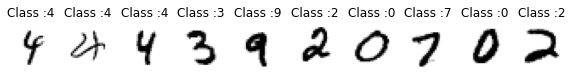

In [26]:
pltsize = 1
plt.figure(figsize=(pltsize*10, pltsize))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap='gray_r')
    plt.title('Class :' + str(y_train[i].item()))

In [47]:
from torch import dropout


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.LSTM(input_size=512, hidden_size=128, dropout=0.3)
        self.fc3 = nn.GRU(input_size=128, hidden_size=32, dropout=0.3)
        self.fc4 = nn.Linear(32, 10)

    def forward(self, x):
        x = x.reshape(-1, 28 * 28)
        x = self.fc1(x)
        x = F.relu(x)
        x, _ = self.fc2(x)
        x = F.relu(x)
        x, _ = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.log_softmax(x)
        return x

In [48]:
del model

In [49]:
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.5)
criterion = nn.CrossEntropyLoss()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): LSTM(512, 128, dropout=0.3)
  (fc3): GRU(128, 32, dropout=0.3)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)


c:\Users\Admin\anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [50]:
def train(model, train_loader, optimizer, log_intervals=100):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        output = model(image)
        optimizer.zero_grad()
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_intervals == 0:
            print('Train_Epoch : {}, [{} / {}]({:.0f}%)\tTrain_loss : {:.6f}'.format(
                Epoch, batch_idx * len(image),
                len(train_loader.dataset), 100 * batch_idx / len(train_loader),
                loss.item()
            ))

In [51]:
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    test_loss = 0
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss = criterion(output, label)
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
        test_loss /= len(test_loader)
        test_accuracy = 100 * correct / len(test_loader.dataset)
        return test_loss, test_accuracy

In [52]:
best_accuracy = 0
es = 0
for Epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer)
    test_loss , test_accuracy =  evaluate(model, test_loader)
    if test_accuracy > best_accuracy :
        best_model = model
        best_accuracy = test_accuracy
        es = 0
    else :
        es += 1
    if es == 30 :
        break
    print('\n[EPOCH : {}, \tTest_loss : {:.4f}, \tTest_Accuracy : {:.2f}%\n'.format(
        Epoch, test_loss, test_accuracy
    ))

C:\Users\Admin\AppData\Local\Temp\ipykernel_24088\1859708491.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train_Epoch : 1, [0 / 60000](0%)	Train_loss : 2.307260
Train_Epoch : 1, [12800 / 60000](21%)	Train_loss : 2.311649
Train_Epoch : 1, [25600 / 60000](43%)	Train_loss : 2.305882
Train_Epoch : 1, [38400 / 60000](64%)	Train_loss : 2.289255
Train_Epoch : 1, [51200 / 60000](85%)	Train_loss : 2.288316

[EPOCH : 1, 	Test_loss : 0.0291, 	Test_Accuracy : 19.14%

Train_Epoch : 2, [0 / 60000](0%)	Train_loss : 2.286023
Train_Epoch : 2, [12800 / 60000](21%)	Train_loss : 2.295238
Train_Epoch : 2, [25600 / 60000](43%)	Train_loss : 2.276044
Train_Epoch : 2, [38400 / 60000](64%)	Train_loss : 2.271126
Train_Epoch : 2, [51200 / 60000](85%)	Train_loss : 2.277165

[EPOCH : 2, 	Test_loss : 0.0287, 	Test_Accuracy : 27.08%

Train_Epoch : 3, [0 / 60000](0%)	Train_loss : 2.265516
Train_Epoch : 3, [12800 / 60000](21%)	Train_loss : 2.249424
Train_Epoch : 3, [25600 / 60000](43%)	Train_loss : 2.241066
Train_Epoch : 3, [38400 / 60000](64%)	Train_loss : 2.203709
Train_Epoch : 3, [51200 / 60000](85%)	Train_loss : 2.1896

In [53]:
print('최고 정확도 : ', best_accuracy)

최고 정확도 :  98.0
